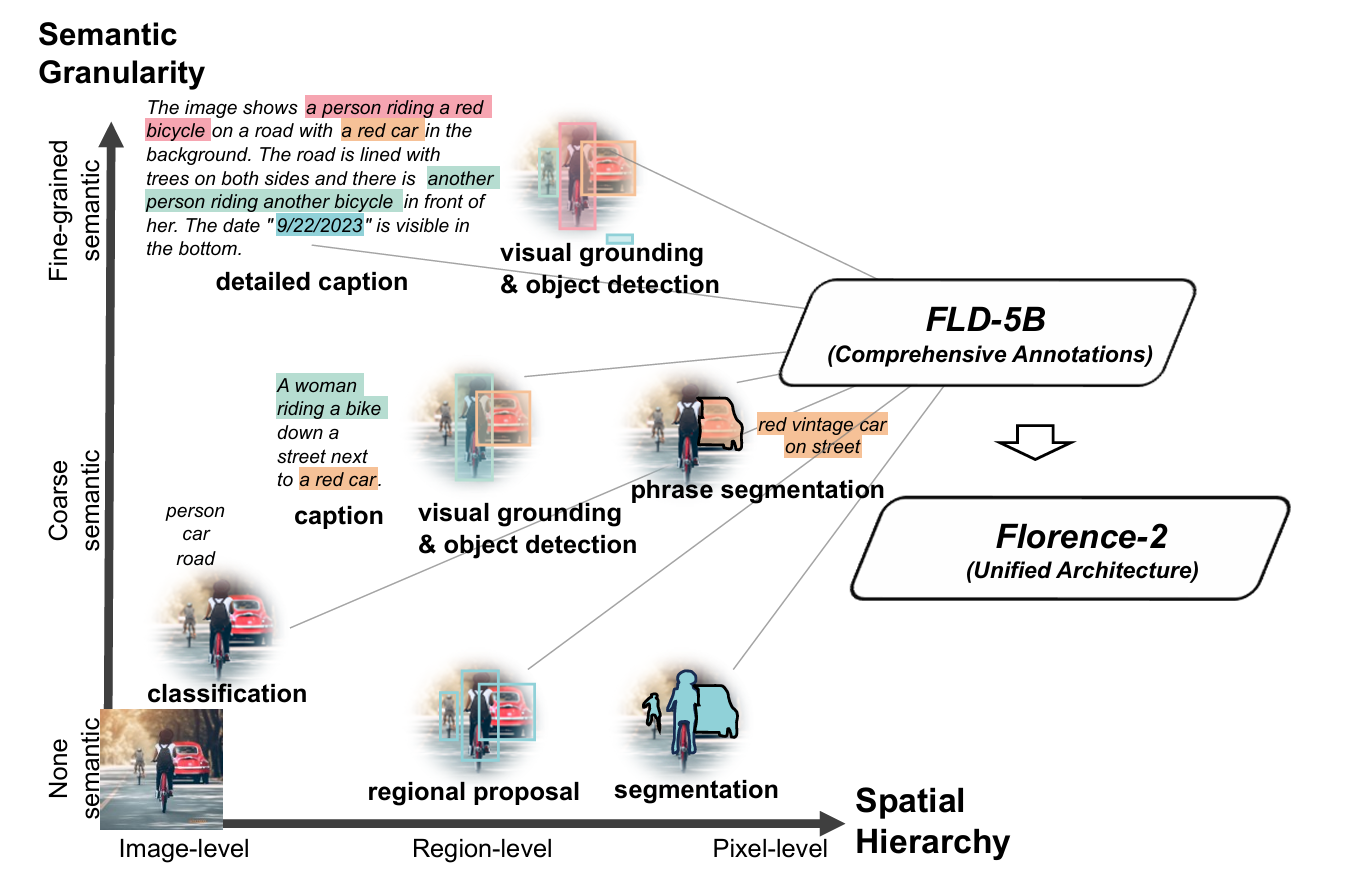

# Fine-tuning Florence-2 to Dectect the freshness of the Products

let's finetune Florence-2 to Dectect the freshness of the Products

In [1]:
!pip install -q datasets flash_attn timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd

# Function to generate a CSV file from folder structure
def create_csv_from_folders(data_dir, output_csv_path):
    image_paths = []
    labels = []

    # Loop through each folder (which represents a class)
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)

        # Check if it's a directory (and not a file)
        if os.path.isdir(label_path):
            # Loop through each image in the class folder
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)

                # Check if it's an image file (you can filter specific extensions)
                if image_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(image_path)
                    labels.append(label)

    # Create a DataFrame with two columns: image_path and label
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # # Save the DataFrame as a CSV file
    # df.to_csv(output_csv_path, index=False)
    # print(f"CSV file created at: {output_csv_path}")
    return df

# Define the paths
train_dir = '/content/drive/MyDrive/FLIPKART_TEST'  # Replace with your actual path
# test_dir = '/path/to/dataset/test'    # Replace with your actual path

train_csv = 'train.csv'
# test_csv = 'test.csv'

# Create CSV for train and test datasets
ds_train=create_csv_from_folders(train_dir, train_csv)
# ds_test=create_csv_from_folders(test_dir, test_csv)


In [7]:
import pandas as pd
import re
import random
df1 = pd.DataFrame(ds_train)

# Function to extract the fruit name from the image path
def update_fresh_label(row):
    if row['label'] == 'fresh':
        # Extract the part of the filename that follows "fresh"
        match = re.search(r'fresh(\w+)', row['image_path'])
        if match:
            return f"fresh{match.group(1)}"
    elif row['label'] == 'rotten':
        # Extract the part of the filename that follows "fresh"
        match = re.search(r'rotten(\w+)', row['image_path'])
        if match:
            return f"rotten{match.group(1)}"
    return row['label']

# Apply the function to update the labels
df1['label'] = df1.apply(update_fresh_label, axis=1)

# Function to assign freshness index based on label
def assign_freshness(label):
    if label.startswith('rotten'):
        return f"{label}_with freshness index {random.randint(1, 4)}"
    elif label.startswith('fresh'):
        return f"{label}__with freshness index {random.randint(6, 9)}"
    return label  # In case there are other labels

# Apply the function to the 'label' column
df1['label'] = df1['label'].apply(assign_freshness)
# Print the updated DataFrame
print(df1)
ds_train=df1
# Optional: Save the updated DataFrame to CSV
# df.to_csv('updated_fresh_dataset.csv', index=False)


                                             image_path  \
0     /content/drive/MyDrive/FLIPKART_TEST/rotten/ro...   
1     /content/drive/MyDrive/FLIPKART_TEST/rotten/ro...   
2     /content/drive/MyDrive/FLIPKART_TEST/rotten/ro...   
3     /content/drive/MyDrive/FLIPKART_TEST/rotten/ro...   
4     /content/drive/MyDrive/FLIPKART_TEST/rotten/ro...   
...                                                 ...   
1060  /content/drive/MyDrive/FLIPKART_TEST/fresh/fre...   
1061  /content/drive/MyDrive/FLIPKART_TEST/fresh/fre...   
1062  /content/drive/MyDrive/FLIPKART_TEST/fresh/fre...   
1063  /content/drive/MyDrive/FLIPKART_TEST/fresh/fre...   
1064  /content/drive/MyDrive/FLIPKART_TEST/fresh/fre...   

                                      label  
0      rottenApple_2_with freshness index 2  
1      rottenApple_1_with freshness index 3  
2      rottenApple_3_with freshness index 3  
3      rottenApple_2_with freshness index 1  
4      rottenApple_1_with freshness index 1  
...            

In [8]:
import pandas as pd
from datasets import Dataset, DatasetDict
from PIL import Image

# Assuming your DataFrame is like this:
# Example data (replace this with your actual DataFrame loading)
# df = pd.DataFrame(ds_train)

# Convert the DataFrame to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(ds_train)

# Function to load the image when accessing the 'image_path' column
def load_image(example):
    return {
        'image': Image.open(example['image_path'])
    }

# Apply the load_image function to load images from the file paths
hf_dataset = hf_dataset.map(load_image, remove_columns=['image_path'])

# Now split the dataset into train and test
train_dataset = hf_dataset.select(range(200))  # Assuming 138 rows for train
test_dataset = hf_dataset.select(range(200, 240))  # Assuming 30 rows for test

# Create the DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Example: Accessing the first image in the train dataset
image = dataset_dict['train'][0]['image']
image.show()  # This will display the image if you're running this in an environment with a display

# You can also check the structure of the DatasetDict
print(dataset_dict)


Map:   0%|          | 0/1065 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 200
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 40
    })
})


In [9]:
from datasets import concatenate_datasets, DatasetDict

# Filter the dataset to get 100 examples with labels that start with "rotten"
rotten_dataset = hf_dataset.filter(lambda example: example['label'].startswith('rotten')).select(range(100))

# Filter the dataset to get 100 examples with labels that start with "fresh"
fresh_dataset = hf_dataset.filter(lambda example: example['label'].startswith('fresh')).select(range(100))

# Concatenate the 100 "rotten" and 100 "fresh" examples into a single training dataset
train_dataset = concatenate_datasets([rotten_dataset, fresh_dataset])

# Create a test dataset (selecting 30 examples, as in your original code)
test_dataset = hf_dataset.select(range(500, 530))  # Adjust indices as needed for your data

# Create the DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Example: Accessing the first image in the train dataset
# image = dataset_dict['train'][0]['image']
# image.show()  # This will display the image if you're running this in an environment with a display

# Check the structure of the DatasetDict
print(dataset_dict)


Filter:   0%|          | 0/1065 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1065 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 200
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 30
    })
})


In [10]:
ds_train=dataset_dict['train']
ds_test=dataset_dict['test']


We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [31]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)

processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

cuda


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [36]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


In [ ]:
from PIL import Image
import torch

EXAMPLE_IMAGE_PATH='/content/WhatsApp Image 2024-10-20 at 2.15.52 AM.jpeg'
image = Image.open(EXAMPLE_IMAGE_PATH)
# task = "<DocVQA>"

# # Text prompt specifically asking to extract expiry date, brand details, packet size, brand name, and MRP from the product label
# text = """
# <DocVQA> Please extract the following details from the product label in this image:
# 1. Expiry Date (formatted as MM/YYYY or DD/MM/YYYY).
# 2. Brand Details (name of the brand).
# 3. Packet Size (quantity or volume).
# 4. MRP (Maximum Retail Price).

{'OCR': '05 0724 04 0725'}
{'DocVQA': 'unanswerable'}
{'DocVQA': '40g'}
{'OPEN_VOCABULARY_DETECTION': '$3.49'}


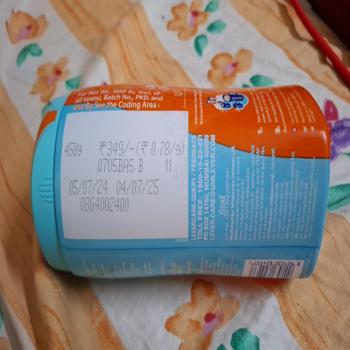

{'OCR': '05 0724 04 0725'}
{'DocVQA': 'unanswerable'}
{'DocVQA': '40g'}
{'OPEN_VOCABULARY_DETECTION': '$3.49'}


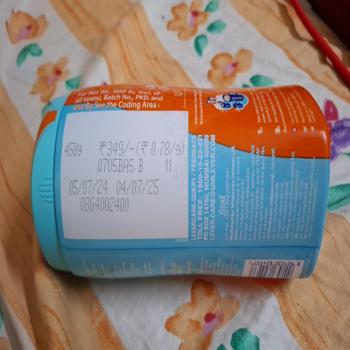

{'OCR': '05 0724 04 0725'}
{'DocVQA': 'unanswerable'}
{'DocVQA': '40g'}
{'OPEN_VOCABULARY_DETECTION': '$3.49'}


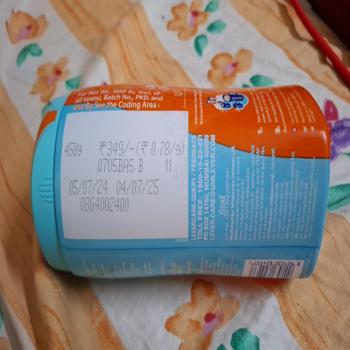

In [ ]:
# Loop through the dataset and run the DocVQA task to extract multiple details
for idx in range(3):
    # For each item in the dataset, ask questions about the expiry date, brand details, etc.

    # Asking for the expiry date
    print(run_example("OCR", 'What is the expiry date of the product ?', image))

    # Asking for the brand details (name of the brand)
    print(run_example("DocVQA", 'What is the brand name of the product?', image))

    # Asking for the packet size (quantity or volume)
    print(run_example("DocVQA", 'What is the packet size or quantity of the product?', image))

    # Asking for the MRP (Maximum Retail Price)
    print(run_example("OPEN_VOCABULARY_DETECTION", 'What is the cost of the product in Rupees?', image))

    # Display the image resized to 350x350 for better visualization
    display(image.resize([350, 350]))


{'DocVQA': 'rottenApple'}


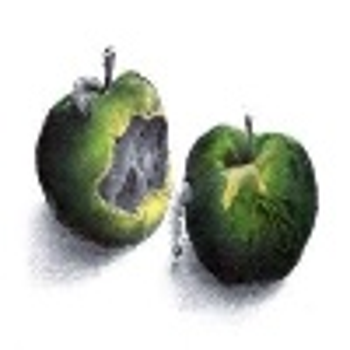

{'DocVQA': 'rottenApple'}


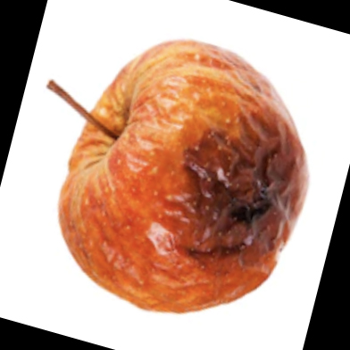

{'DocVQA': 'rottenApple'}


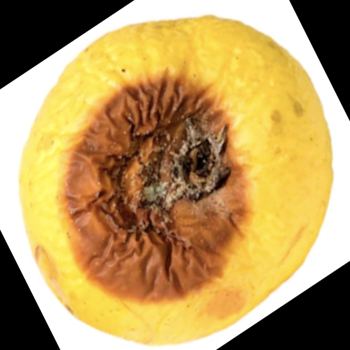

In [119]:
for idx in range(3):
  print(run_example("DocVQA", 'What is the name of the fruit?', ds_train[idx]['image']))
  display(ds_train[idx]['image'].resize([350, 350]))

create a custo dataloader with `<DocVQA> `


In [12]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" +'What is the freshness index in the scale of 10?'
        answer = example['label']
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, answer, image


In [13]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets

train_dataset = DocVQADataset(ds_train)
val_dataset = DocVQADataset(ds_test)

# Create DataLoader
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [64]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir1 = f"./model_checkpoints/epoch_{epoch+1}"
        output_dir2 = f"./processor_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir1, exist_ok=True)
        os.makedirs(output_dir2, exist_ok=True)
        model.save_pretrained(output_dir1)
        processor.save_pretrained(output_dir2)


We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [15]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [16]:
train_model(train_loader, val_loader, model, processor, epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/2: 100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


Average Training Loss: 2.2468916969001294


Validation Epoch 1/2: 100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Average Validation Loss: 1.166953965028127


Training Epoch 2/2: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


Average Training Loss: 0.8746804328262806


Validation Epoch 2/2: 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Average Validation Loss: 1.0570364892482758


In [23]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': 'freshBanana_7_with freshness index 7'}


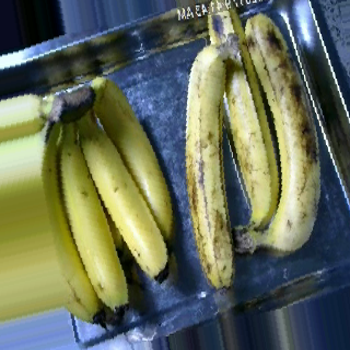

In [30]:

print(run_example("DocVQA", 'What is the freshness index in the scale of 10?', ds_train[199]['image']))
display(ds_train[199]['image'].resize([350, 350]))

### MRP, EXR Date, Brand Name etc. Dectection

In [39]:
import pandas as pd
from datasets import Dataset, DatasetDict, Features, ClassLabel, Image as HFImage
from PIL import Image

# Load your DataFrame from the Excel file (or any other source)
df = pd.read_excel('/content/drive/MyDrive/CUSTOM_PRODUCTS/DATASET_Final1.xlsx')  # Update with the correct path

# Ensure the DataFrame has 'image_path' and 'label' columns
df = df[['Image', 'Label']]

# Convert the DataFrame to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

# Function to load images using PIL
def load_image(example):
    try:
        image = Image.open(example['Image']).convert('RGB')  # Ensure consistent image format
        return {'image': image}
    except Exception as e:
        print(f"Error loading image {example['Image']}: {e}")
        return {'image': None}  # Handle any issues with loading

# Apply the load_image function to load images
hf_dataset = hf_dataset.map(load_image, remove_columns=['Image'])

# Split the dataset into train and test (80% train, 20% test split)
train_size = int(0.95 * len(hf_dataset))
test_size = len(hf_dataset) - train_size

train_dataset = hf_dataset.select(range(train_size))
test_dataset = hf_dataset.select(range(train_size, train_size + test_size))

# Create a DatasetDict containing the train and test datasets
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# Example: Access and display the first image in the train dataset (if in a display-capable environment)
image = dataset_dict['train'][0]['image']
if image:
    image.show()

# Print the structure of the DatasetDict
print(dataset_dict)


Map:   0%|          | 0/22 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Label', 'image'],
        num_rows: 20
    })
    test: Dataset({
        features: ['Label', 'image'],
        num_rows: 2
    })
})


In [40]:
ds_train=dataset_dict['train']
ds_test=dataset_dict['test']


In [41]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" +'What is the MRP, Brand Name and Exp date of the product?'
        answer = example['Label']
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, answer, image


In [42]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets

train_dataset = DocVQADataset(ds_train)
val_dataset = DocVQADataset(ds_test)

# Create DataLoader
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [65]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir1 = f"./model_checkpoints/epoch_{epoch+1}"
        output_dir2 = f"./processor_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir1, exist_ok=True)
        os.makedirs(output_dir2, exist_ok=True)
        model.save_pretrained(output_dir1)
        processor.save_pretrained(output_dir2)


In [66]:
for param in model.vision_tower.parameters():
  param.is_trainable = False
train_model(train_loader, val_loader, model, processor, epochs=20)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Average Training Loss: 0.8568295780569315


Validation Epoch 1/20: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


Average Validation Loss: 4.611888647079468


Training Epoch 2/20: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Average Training Loss: 0.7545441634953022


Validation Epoch 2/20: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Average Validation Loss: 4.647395372390747


Training Epoch 3/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.6522672448307276


Validation Epoch 3/20: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Average Validation Loss: 4.7081780433654785


Training Epoch 4/20: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Average Training Loss: 0.5754770588129758


Validation Epoch 4/20: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Average Validation Loss: 4.666978359222412


Training Epoch 5/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.6198652058839798


Validation Epoch 5/20: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Average Validation Loss: 4.649489641189575


Training Epoch 6/20: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Average Training Loss: 0.5271092614158988


Validation Epoch 6/20: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


Average Validation Loss: 4.692580938339233


Training Epoch 7/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.43119072187691926


Validation Epoch 7/20: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Average Validation Loss: 4.664127826690674


Training Epoch 8/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.4657939800992608


Validation Epoch 8/20: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Average Validation Loss: 4.6388373374938965


Training Epoch 9/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.41337078912183645


Validation Epoch 9/20: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Average Validation Loss: 4.6491241455078125


Training Epoch 10/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.4122863482683897


Validation Epoch 10/20: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


Average Validation Loss: 4.666807174682617


Training Epoch 11/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.3673234526067972


Validation Epoch 11/20: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Average Validation Loss: 4.644451379776001


Training Epoch 12/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.36456675324589016


Validation Epoch 12/20: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Average Validation Loss: 4.671612977981567


Training Epoch 13/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.38729814887046815


Validation Epoch 13/20: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Average Validation Loss: 4.67762303352356


Training Epoch 14/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.35940413512289526


Validation Epoch 14/20: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Average Validation Loss: 4.68187141418457


Training Epoch 15/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.3205837670713663


Validation Epoch 15/20: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Average Validation Loss: 4.673046827316284


Training Epoch 16/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Average Training Loss: 0.2965596353635192


Validation Epoch 16/20: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Average Validation Loss: 4.671181678771973


Training Epoch 17/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.2887831525877118


Validation Epoch 17/20: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


Average Validation Loss: 4.671620607376099


Training Epoch 18/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.30110885510221125


Validation Epoch 18/20: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Average Validation Loss: 4.679076433181763


Training Epoch 19/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.2977705469354987


Validation Epoch 19/20: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Average Validation Loss: 4.683792591094971


Training Epoch 20/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Average Training Loss: 0.28397732246667146


Validation Epoch 20/20: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Average Validation Loss: 4.6838295459747314


In [50]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': 'MRP is Rs 53 and Exp date is 04/24'}


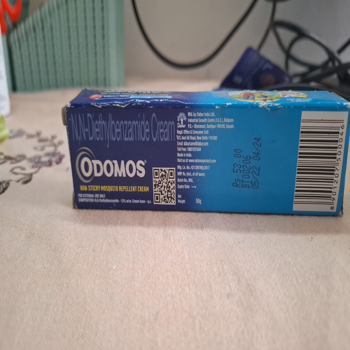

In [63]:
print(run_example("DocVQA", 'What is the MRP, Brand Name and Exp date of the product if visible in the picture?', ds_train[7]['image']))
display(ds_train[7]['image'].resize([350, 350]))